In [1]:
# calculate enrichment in chromHMM, histone marks
import os,sys
#add other packagaes
from scipy.stats import chi2_contingency
from scipy.stats import zscore
from adjustText import adjust_text
from statannotations.Annotator import Annotator

#https://www.statsmodels.org/0.8.0/generated/statsmodels.sandbox.stats.multicomp.multipletests.html
from statsmodels.sandbox.stats.multicomp import multipletests as mlpt

In [2]:
import pandas as pd
import scipy.stats as ss
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pybedtools import BedTool

In [3]:
commonFontsize=8

def config_rcparams():    
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['font.sans-serif'] = ['arial']
    plt.rcParams['font.size'] = commonFontsize
    plt.rcParams['axes.labelsize'] = commonFontsize
    plt.rcParams['xtick.labelsize'] = commonFontsize
    plt.rcParams['ytick.labelsize'] = commonFontsize
    plt.rcParams['axes.titlesize'] = commonFontsize
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.cal'] = 'arial'
    plt.rcParams['mathtext.rm'] = 'arial' 
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['axes.linewidth'] = 0.7
    plt.rcParams['xtick.major.width'] = 0.7
    plt.rcParams['ytick.major.width'] = 0.7
    plt.rcParams['xtick.major.size' ] = 3
    plt.rcParams['ytick.major.size' ] = 3

config_rcparams()



In [4]:
# HPV integrations, genome wide set, extended by 500 bp on both sides, hg19
combined=pd.read_csv('../dataset/final_data/hpv_int/genome-wide_flanks_500bp.tsv', sep='\t')
combined

,chrom,1,2,sample,method,Author
0,chr2,195585894,195586894,TCGA-C5-A0TN,WGS,vifi
1,chr3,126848536,126849536,TCGA-C5-A0TN,WGS,vifi
2,chr4,29068978,29069978,TCGA-C5-A1BF,WGS,vifi
3,chr4,29070579,29071579,TCGA-C5-A1BF,WGS,vifi
4,chr4,74538426,74539426,TCGA-C5-A1BJ,WGS,vifi
5,chr4,74668009,74669009,TCGA-C5-A1BJ,WGS,vifi
6,chr18,61276376,61277376,TCGA-C5-A1BN,WGS,vifi
7,chr18,61373179,61374179,TCGA-C5-A1BN,WGS,vifi
8,chr10,97268532,97269532,TCGA-C5-A1M8,WGS,vifi
9,chr10,97517881,97518881,TCGA-C5-A1M8,WGS,vifi


In [5]:
print((combined['2']-combined['1']).value_counts())
print(combined['sample'].nunique())

1000    617
dtype: int64
212


In [6]:
#convert to bed
combined_bed=BedTool.from_dataframe(combined).sort()
print(len(combined_bed))
combined_bed.head()

617
chr1	10697044	10698044	T02319	Hybrid-capture; Multiplex RT-PCR; APOT	Xu B
 chr1	10697983	10698983	TCGA-DG-A2KJ	WGS	vifi
 chr1	10698781	10699781	T02319	Hybrid-capture; Multiplex RT-PCR; APOT	Xu B
 chr1	10706930	10707930	T02319	Hybrid-capture; Multiplex RT-PCR; APOT	Xu B
 chr1	12486127	12487127	TCGA-EA-A3HQ	WGS	vifi
 chr1	12556559	12557559	TCGA-EA-A3HQ	WGS	vifi
 chr1	12631448	12632448	HOM0126	Hybrid-capture	Holmes A
 chr1	12634259	12635259	HOM0126	Hybrid-capture	Holmes A
 chr1	31618152	31619152	TM0035	Hybrid-capture; Sanger sequencing	Lui Y
 chr1	38487232	38488232	TCGA-EK-A2RE	WGS	vifi
 

In [7]:
#random gc corrected regions, total length 1 kb
ran_sites_gc=pd.read_csv('../dataset/final_data/hpv_int/random_gc_corr_1kb.tsv', sep='\t')
ran_sites_gc

,chr,start,end
0,chr6,98232979,98233979
1,chr10,28292609,28293609
2,chr1,198767263,198768263
3,chr15,97654854,97655854
4,chr2,235812936,235813936
5,chr12,51120001,51121001
6,chrX,40813161,40814161
7,chr12,47972758,47973758
8,chr7,105556655,105557655
9,chr9,100772751,100773751


In [8]:
(ran_sites_gc['end']-ran_sites_gc['start']).value_counts()

1000    617
dtype: int64

In [9]:
#convert into bed
ran_sites_gc_bed=BedTool.from_dataframe(ran_sites_gc).sort()
print(len(ran_sites_gc_bed))
ran_sites_gc_bed.head()

617
chr1	3149623	3150623
 chr1	3585742	3586742
 chr1	7617100	7618100
 chr1	8127302	8128302
 chr1	9519689	9520689
 chr1	12965798	12966798
 chr1	19927383	19928383
 chr1	25041512	25042512
 chr1	25833823	25834823
 chr1	26044145	26045145
 

# histones

In [10]:
# calculate no of int sites overlapping with each of the histone file
frames=[]
for file in os.listdir('/workspace/incubator/aks/hela_haplotype/dataset/sabari_encode/histone'):
    if file.endswith('.gz'):
        file_hist=pd.read_csv('/workspace/incubator/aks/hela_haplotype/dataset/sabari_encode/histone/' + file, sep='\t', header=None)
        file_hist=file_hist[[0,1,2]]
        #to bed
        file_hist_bed=BedTool.from_dataframe(file_hist).sort()
        print(len(file_hist_bed))
        print(file)
        # intersect with hpv integrations
        inter=combined_bed.intersect(file_hist_bed, c=True, sorted=True)
        inter=BedTool.to_dataframe(inter)
        inter=inter[inter['thickStart']!=0]
        no_int=len(inter)
        no_sample=inter['name'].nunique()
        frames.append([file,no_int,no_sample])
hist_df=pd.DataFrame(frames, columns=['hist','no_sites_overlapping', 'no_samples'])
hist_df

222220
wgEncodeBroadHistoneHelas3H4k20me1StdPk.broadPeak.gz
30439
wgEncodeBroadHistoneHelas3H3k36me3StdPk.broadPeak.gz
46471
wgEncodeBroadHistoneHelas3H3k27acStdPk.broadPeak.gz
98967
wgEncodeBroadHistoneNhekH3k4me2StdPk.broadPeak.gz
81013
wgEncodeBroadHistoneHelas3H3k4me2StdPk.broadPeak.gz
43496
wgEncodeBroadHistoneNhekH3k36me3StdPk.broadPeak.gz
34142
wgEncodeBroadHistoneNhekH3k79me2Pk.broadPeak.gz
150631
wgEncodeBroadHistoneNhekH2azPk.broadPeak.gz
198646
wgEncodeBroadHistoneNhekEzh239875Pk.broadPeak.gz
40410
wgEncodeBroadHistoneHelas3H3k9acStdPk.broadPeak.gz
75205
wgEncodeBroadHistoneNhekH3k09me3Pk.broadPeak.gz
91807
wgEncodeBroadHistoneHelas3CtcfStdPk.broadPeak.gz
51868
wgEncodeBroadHistoneNhekH3k9acStdPk.broadPeak.gz
56505
wgEncodeBroadHistoneNhekPol2bStdPk.broadPeak.gz
49258
wgEncodeBroadHistoneNhekH3k27me3StdPk.broadPeak.gz
100852
wgEncodeBroadHistoneHelas3Pol2bStdPk.broadPeak.gz
107420
wgEncodeBroadHistoneHelas3H3k04me1StdPk.broadPeak.gz
78212
wgEncodeBroadHistoneHelas3H3k09me3Pk

,hist,no_sites_overlapping,no_samples
0,wgEncodeBroadHistoneHelas3H4k20me1StdPk.broadP...,178,88
1,wgEncodeBroadHistoneHelas3H3k36me3StdPk.broadP...,234,107
2,wgEncodeBroadHistoneHelas3H3k27acStdPk.broadPe...,123,69
3,wgEncodeBroadHistoneNhekH3k4me2StdPk.broadPeak.gz,151,98
4,wgEncodeBroadHistoneHelas3H3k4me2StdPk.broadPe...,145,87
5,wgEncodeBroadHistoneNhekH3k36me3StdPk.broadPea...,225,108
6,wgEncodeBroadHistoneNhekH3k79me2Pk.broadPeak.gz,147,74
7,wgEncodeBroadHistoneNhekH2azPk.broadPeak.gz,242,126
8,wgEncodeBroadHistoneNhekEzh239875Pk.broadPeak.gz,167,92
9,wgEncodeBroadHistoneHelas3H3k9acStdPk.broadPea...,151,69


In [11]:
hist_df['hist'].nunique()

29

In [12]:
#check
print(file)
print(len(inter))
print(inter['name'].nunique())
inter.head()

wgEncodeBroadHistoneNhekH3k4me1StdPk.broadPeak.gz
183
110


,chrom,start,end,name,score,strand,thickStart
0,chr1,10697044,10698044,T02319,Hybrid-capture; Multiplex RT-PCR; APOT,Xu B,1
1,chr1,10697983,10698983,TCGA-DG-A2KJ,WGS,vifi,1
2,chr1,10698781,10699781,T02319,Hybrid-capture; Multiplex RT-PCR; APOT,Xu B,1
3,chr1,10706930,10707930,T02319,Hybrid-capture; Multiplex RT-PCR; APOT,Xu B,1
7,chr1,12634259,12635259,HOM0126,Hybrid-capture,Holmes A,1


In [13]:
# calculate no of random sites overlapping with each of the histone file
frames=[]
for file in os.listdir('/workspace/incubator/aks/hela_haplotype/dataset/sabari_encode/histone'):
    if file.endswith('.gz'):
        file_hist=pd.read_csv('/workspace/incubator/aks/hela_haplotype/dataset/sabari_encode/histone/' + file, sep='\t', header=None)
        file_hist=file_hist[[0,1,2]]
        #to bed
        file_hist_bed=BedTool.from_dataframe(file_hist).sort()
        print(len(file_hist_bed))
        print(file)
        # intersect with random sites
        inter=ran_sites_gc_bed.intersect(file_hist_bed, c=True, sorted=True)
        inter=BedTool.to_dataframe(inter)
        inter=inter[inter['name']!=0]
        no_overlap=len(inter)
        #no_sample=inter['name'].nunique()
        frames.append([file,no_overlap])
        
hist_random=pd.DataFrame(frames, columns=['hist','no_randomSites_overlapping'])
hist_random

222220
wgEncodeBroadHistoneHelas3H4k20me1StdPk.broadPeak.gz
30439
wgEncodeBroadHistoneHelas3H3k36me3StdPk.broadPeak.gz
46471
wgEncodeBroadHistoneHelas3H3k27acStdPk.broadPeak.gz
98967
wgEncodeBroadHistoneNhekH3k4me2StdPk.broadPeak.gz
81013
wgEncodeBroadHistoneHelas3H3k4me2StdPk.broadPeak.gz
43496
wgEncodeBroadHistoneNhekH3k36me3StdPk.broadPeak.gz
34142
wgEncodeBroadHistoneNhekH3k79me2Pk.broadPeak.gz
150631
wgEncodeBroadHistoneNhekH2azPk.broadPeak.gz
198646
wgEncodeBroadHistoneNhekEzh239875Pk.broadPeak.gz
40410
wgEncodeBroadHistoneHelas3H3k9acStdPk.broadPeak.gz
75205
wgEncodeBroadHistoneNhekH3k09me3Pk.broadPeak.gz
91807
wgEncodeBroadHistoneHelas3CtcfStdPk.broadPeak.gz
51868
wgEncodeBroadHistoneNhekH3k9acStdPk.broadPeak.gz
56505
wgEncodeBroadHistoneNhekPol2bStdPk.broadPeak.gz
49258
wgEncodeBroadHistoneNhekH3k27me3StdPk.broadPeak.gz
100852
wgEncodeBroadHistoneHelas3Pol2bStdPk.broadPeak.gz
107420
wgEncodeBroadHistoneHelas3H3k04me1StdPk.broadPeak.gz
78212
wgEncodeBroadHistoneHelas3H3k09me3Pk

,hist,no_randomSites_overlapping
0,wgEncodeBroadHistoneHelas3H4k20me1StdPk.broadP...,140
1,wgEncodeBroadHistoneHelas3H3k36me3StdPk.broadP...,142
2,wgEncodeBroadHistoneHelas3H3k27acStdPk.broadPe...,48
3,wgEncodeBroadHistoneNhekH3k4me2StdPk.broadPeak.gz,67
4,wgEncodeBroadHistoneHelas3H3k4me2StdPk.broadPe...,72
5,wgEncodeBroadHistoneNhekH3k36me3StdPk.broadPea...,122
6,wgEncodeBroadHistoneNhekH3k79me2Pk.broadPeak.gz,94
7,wgEncodeBroadHistoneNhekH2azPk.broadPeak.gz,151
8,wgEncodeBroadHistoneNhekEzh239875Pk.broadPeak.gz,162
9,wgEncodeBroadHistoneHelas3H3k9acStdPk.broadPea...,50


In [14]:
hist_random['hist'].nunique()

29

In [15]:
#check
print(file)
print(len(inter))
inter.head()

wgEncodeBroadHistoneNhekH3k4me1StdPk.broadPeak.gz
85


,chrom,start,end,name
7,chr1,25041512,25042512,1
15,chr1,34885321,34886321,1
19,chr1,44024004,44025004,1
24,chr1,78442401,78443401,1
25,chr1,82949722,82950722,1


In [16]:
# merge with hist df
hist_df=hist_df.merge(hist_random, on='hist', how='left')
hist_df

,hist,no_sites_overlapping,no_samples,no_randomSites_overlapping
0,wgEncodeBroadHistoneHelas3H4k20me1StdPk.broadP...,178,88,140
1,wgEncodeBroadHistoneHelas3H3k36me3StdPk.broadP...,234,107,142
2,wgEncodeBroadHistoneHelas3H3k27acStdPk.broadPe...,123,69,48
3,wgEncodeBroadHistoneNhekH3k4me2StdPk.broadPeak.gz,151,98,67
4,wgEncodeBroadHistoneHelas3H3k4me2StdPk.broadPe...,145,87,72
5,wgEncodeBroadHistoneNhekH3k36me3StdPk.broadPea...,225,108,122
6,wgEncodeBroadHistoneNhekH3k79me2Pk.broadPeak.gz,147,74,94
7,wgEncodeBroadHistoneNhekH2azPk.broadPeak.gz,242,126,151
8,wgEncodeBroadHistoneNhekEzh239875Pk.broadPeak.gz,167,92,162
9,wgEncodeBroadHistoneHelas3H3k9acStdPk.broadPea...,151,69,50


In [17]:
hist_df['no_samples'].describe()

count     29.000000
mean      87.448276
std       22.446104
min       43.000000
25%       69.000000
50%       87.000000
75%      103.000000
max      134.000000
Name: no_samples, dtype: float64

In [18]:
# making 2x2 contingency table and doing chi square test for each hist
frames=[]
for index, row in hist_df.iterrows():
    obs=np.array([[row['no_sites_overlapping'], 617-row['no_sites_overlapping']],\
                  [row['no_randomSites_overlapping'], 617-row['no_randomSites_overlapping']]])
    
    print(obs)
    chi2, p, dof, expected = chi2_contingency(obs)
    print(p)
    frames.append([row['hist'], p])
    
#create df for chi square pvals
hist_pval=pd.DataFrame(frames, columns=['hist', 'chi-pval'])
print(len(hist_pval))

# merge with original df
hist_df=hist_df.merge(hist_pval, on='hist', how='left')
hist_df

[[178 439]
 [140 477]]
0.01603006763600141
[[234 383]
 [142 475]]
1.8221092203013605e-08
[[123 494]
 [ 48 569]]
1.0799768721968674e-09
[[151 466]
 [ 67 550]]
5.81834456164252e-10
[[145 472]
 [ 72 545]]
7.287520646881667e-08
[[225 392]
 [122 495]]
1.0575063856689062e-10
[[147 470]
 [ 94 523]]
0.00018844019355101173
[[242 375]
 [151 466]]
3.8134562050696354e-08
[[167 450]
 [162 455]]
0.796784532009231
[[151 466]
 [ 50 567]]
1.266075007812334e-14
[[143 474]
 [146 471]]
0.8930560616706676
[[164 453]
 [ 82 535]]
7.85201803526919e-09
[[113 504]
 [ 52 565]]
5.206372622144046e-07
[[173 444]
 [ 92 525]]
2.926443788105319e-08
[[ 93 524]
 [135 482]]
0.0026358989936405572
[[289 328]
 [185 432]]
1.6563664815842961e-09
[[189 428]
 [ 88 529]]
8.929184968813698e-12
[[210 407]
 [185 432]]
0.1430574591967222
[[ 65 552]
 [ 40 577]]
0.014339161510959262
[[270 347]
 [183 434]]
3.793519791521278e-07
[[120 497]
 [ 56 561]]
2.919023840548599e-07
[[137 480]
 [ 58 559]]
1.1480659192839509e-09
[[174 443]
 [171 4

,hist,no_sites_overlapping,no_samples,no_randomSites_overlapping,chi-pval
0,wgEncodeBroadHistoneHelas3H4k20me1StdPk.broadP...,178,88,140,1.603007e-02
1,wgEncodeBroadHistoneHelas3H3k36me3StdPk.broadP...,234,107,142,1.822109e-08
2,wgEncodeBroadHistoneHelas3H3k27acStdPk.broadPe...,123,69,48,1.079977e-09
3,wgEncodeBroadHistoneNhekH3k4me2StdPk.broadPeak.gz,151,98,67,5.818345e-10
4,wgEncodeBroadHistoneHelas3H3k4me2StdPk.broadPe...,145,87,72,7.287521e-08
5,wgEncodeBroadHistoneNhekH3k36me3StdPk.broadPea...,225,108,122,1.057506e-10
6,wgEncodeBroadHistoneNhekH3k79me2Pk.broadPeak.gz,147,74,94,1.884402e-04
7,wgEncodeBroadHistoneNhekH2azPk.broadPeak.gz,242,126,151,3.813456e-08
8,wgEncodeBroadHistoneNhekEzh239875Pk.broadPeak.gz,167,92,162,7.967845e-01
9,wgEncodeBroadHistoneHelas3H3k9acStdPk.broadPea...,151,69,50,1.266075e-14


In [19]:
#slice the names
print(hist_df['hist'].str.split('Histone', expand=True)[0].value_counts())
print(hist_df['hist'].str.split('Pk', expand=True)[1].value_counts())

hist_df['hist']=hist_df['hist'].str.replace('wgEncodeBroadHistone', '' )
hist_df['hist']=hist_df['hist'].str.replace('Pk.broadPeak.gz', '' )

hist_df

wgEncodeBroad    29
Name: 0, dtype: int64
.broadPeak.gz    29
Name: 1, dtype: int64


,hist,no_sites_overlapping,no_samples,no_randomSites_overlapping,chi-pval
0,Helas3H4k20me1Std,178,88,140,1.603007e-02
1,Helas3H3k36me3Std,234,107,142,1.822109e-08
2,Helas3H3k27acStd,123,69,48,1.079977e-09
3,NhekH3k4me2Std,151,98,67,5.818345e-10
4,Helas3H3k4me2Std,145,87,72,7.287521e-08
5,NhekH3k36me3Std,225,108,122,1.057506e-10
6,NhekH3k79me2,147,74,94,1.884402e-04
7,NhekH2az,242,126,151,3.813456e-08
8,NhekEzh239875,167,92,162,7.967845e-01
9,Helas3H3k9acStd,151,69,50,1.266075e-14


In [20]:
## add cell type name
def cell_type (row):
    if 'Helas3' in row['hist']:
        return 'Helas3'
    if 'Nhek' in row['hist']:
        return 'Nhek'
    return 'other'

hist_df['cell']= hist_df.apply(cell_type, axis=1)
print(hist_df['cell'].value_counts())
hist_df

Nhek      15
Helas3    14
Name: cell, dtype: int64


,hist,no_sites_overlapping,no_samples,no_randomSites_overlapping,chi-pval,cell
0,Helas3H4k20me1Std,178,88,140,1.603007e-02,Helas3
1,Helas3H3k36me3Std,234,107,142,1.822109e-08,Helas3
2,Helas3H3k27acStd,123,69,48,1.079977e-09,Helas3
3,NhekH3k4me2Std,151,98,67,5.818345e-10,Nhek
4,Helas3H3k4me2Std,145,87,72,7.287521e-08,Helas3
5,NhekH3k36me3Std,225,108,122,1.057506e-10,Nhek
6,NhekH3k79me2,147,74,94,1.884402e-04,Nhek
7,NhekH2az,242,126,151,3.813456e-08,Nhek
8,NhekEzh239875,167,92,162,7.967845e-01,Nhek
9,Helas3H3k9acStd,151,69,50,1.266075e-14,Helas3


In [21]:
# multiple test
hist_df['bh_p']=mlpt(hist_df['chi-pval'], method='fdr_bh')[1]

# calculate difference between observed and expected
hist_df['diff']=hist_df['no_sites_overlapping']-hist_df['no_randomSites_overlapping']
hist_df

,hist,no_sites_overlapping,no_samples,no_randomSites_overlapping,chi-pval,cell,bh_p,diff
0,Helas3H4k20me1Std,178,88,140,1.603007e-02,Helas3,1.936967e-02,38
1,Helas3H3k36me3Std,234,107,142,1.822109e-08,Helas3,5.284117e-08,92
2,Helas3H3k27acStd,123,69,48,1.079977e-09,Helas3,4.756273e-09,75
3,NhekH3k4me2Std,151,98,67,5.818345e-10,Nhek,3.374640e-09,84
4,Helas3H3k4me2Std,145,87,72,7.287521e-08,Helas3,1.625678e-07,73
5,NhekH3k36me3Std,225,108,122,1.057506e-10,Nhek,7.666921e-10,103
6,NhekH3k79me2,147,74,94,1.884402e-04,Nhek,2.732383e-04,53
7,NhekH2az,242,126,151,3.813456e-08,Nhek,9.215852e-08,91
8,NhekEzh239875,167,92,162,7.967845e-01,Nhek,8.558056e-01,5
9,Helas3H3k9acStd,151,69,50,1.266075e-14,Helas3,3.671618e-13,101


In [22]:
#calculate log2(obs/exp) and negative log10(bh_p)
hist_df['log2(obs/exp)']=np.log2((hist_df['no_sites_overlapping']/hist_df['no_randomSites_overlapping']))
hist_df['-log10(bh_p)']=np.log10(hist_df['bh_p'])*-1
hist_df

,hist,no_sites_overlapping,no_samples,no_randomSites_overlapping,chi-pval,cell,bh_p,diff,log2(obs/exp),-log10(bh_p)
0,Helas3H4k20me1Std,178,88,140,1.603007e-02,Helas3,1.936967e-02,38,0.346450,1.712878
1,Helas3H3k36me3Std,234,107,142,1.822109e-08,Helas3,5.284117e-08,92,0.720618,7.277028
2,Helas3H3k27acStd,123,69,48,1.079977e-09,Helas3,4.756273e-09,75,1.357552,8.322733
3,NhekH3k4me2Std,151,98,67,5.818345e-10,Nhek,3.374640e-09,84,1.172316,8.471773
4,Helas3H3k4me2Std,145,87,72,7.287521e-08,Helas3,1.625678e-07,73,1.009984,6.788966
5,NhekH3k36me3Std,225,108,122,1.057506e-10,Nhek,7.666921e-10,103,0.883044,9.115379
6,NhekH3k79me2,147,74,94,1.884402e-04,Nhek,2.732383e-04,53,0.645083,3.563458
7,NhekH2az,242,126,151,3.813456e-08,Nhek,9.215852e-08,91,0.680458,7.035464
8,NhekEzh239875,167,92,162,7.967845e-01,Nhek,8.558056e-01,5,0.043854,0.067625
9,Helas3H3k9acStd,151,69,50,1.266075e-14,Helas3,3.671618e-13,101,1.594549,12.435143


In [23]:
#make short name
pattern= '|'.join(['Nhek', 'Std', '39875', 'Helas3' ])

print(pattern)

hist_df['title']=hist_df['hist'].str.replace(pattern, '')
hist_df

Nhek|Std|39875|Helas3


,hist,no_sites_overlapping,no_samples,no_randomSites_overlapping,chi-pval,cell,bh_p,diff,log2(obs/exp),-log10(bh_p),title
0,Helas3H4k20me1Std,178,88,140,1.603007e-02,Helas3,1.936967e-02,38,0.346450,1.712878,H4k20me1
1,Helas3H3k36me3Std,234,107,142,1.822109e-08,Helas3,5.284117e-08,92,0.720618,7.277028,H3k36me3
2,Helas3H3k27acStd,123,69,48,1.079977e-09,Helas3,4.756273e-09,75,1.357552,8.322733,H3k27ac
3,NhekH3k4me2Std,151,98,67,5.818345e-10,Nhek,3.374640e-09,84,1.172316,8.471773,H3k4me2
4,Helas3H3k4me2Std,145,87,72,7.287521e-08,Helas3,1.625678e-07,73,1.009984,6.788966,H3k4me2
5,NhekH3k36me3Std,225,108,122,1.057506e-10,Nhek,7.666921e-10,103,0.883044,9.115379,H3k36me3
6,NhekH3k79me2,147,74,94,1.884402e-04,Nhek,2.732383e-04,53,0.645083,3.563458,H3k79me2
7,NhekH2az,242,126,151,3.813456e-08,Nhek,9.215852e-08,91,0.680458,7.035464,H2az
8,NhekEzh239875,167,92,162,7.967845e-01,Nhek,8.558056e-01,5,0.043854,0.067625,Ezh2
9,Helas3H3k9acStd,151,69,50,1.266075e-14,Helas3,3.671618e-13,101,1.594549,12.435143,H3k9ac


In [24]:
# remove Ezh2, Ctcf, Pol2b
print(len(hist_df[~hist_df['hist'].str.contains('Ezh2|Ctcf|Pol2b')]))
hist_df[~hist_df['hist'].str.contains('Ezh2|Ctcf|Pol2b')]

23


,hist,no_sites_overlapping,no_samples,no_randomSites_overlapping,chi-pval,cell,bh_p,diff,log2(obs/exp),-log10(bh_p),title
0,Helas3H4k20me1Std,178,88,140,1.603007e-02,Helas3,1.936967e-02,38,0.346450,1.712878,H4k20me1
1,Helas3H3k36me3Std,234,107,142,1.822109e-08,Helas3,5.284117e-08,92,0.720618,7.277028,H3k36me3
2,Helas3H3k27acStd,123,69,48,1.079977e-09,Helas3,4.756273e-09,75,1.357552,8.322733,H3k27ac
3,NhekH3k4me2Std,151,98,67,5.818345e-10,Nhek,3.374640e-09,84,1.172316,8.471773,H3k4me2
4,Helas3H3k4me2Std,145,87,72,7.287521e-08,Helas3,1.625678e-07,73,1.009984,6.788966,H3k4me2
5,NhekH3k36me3Std,225,108,122,1.057506e-10,Nhek,7.666921e-10,103,0.883044,9.115379,H3k36me3
6,NhekH3k79me2,147,74,94,1.884402e-04,Nhek,2.732383e-04,53,0.645083,3.563458,H3k79me2
7,NhekH2az,242,126,151,3.813456e-08,Nhek,9.215852e-08,91,0.680458,7.035464,H2az
9,Helas3H3k9acStd,151,69,50,1.266075e-14,Helas3,3.671618e-13,101,1.594549,12.435143,H3k9ac
10,NhekH3k09me3,143,68,146,8.930561e-01,Nhek,8.990506e-01,-3,-0.029953,0.046216,H3k09me3


In [25]:
hist_df[~hist_df['hist'].str.contains('Ezh2|Ctcf|Pol2b')].sort_values(by=['log2(obs/exp)'])

,hist,no_sites_overlapping,no_samples,no_randomSites_overlapping,chi-pval,cell,bh_p,diff,log2(obs/exp),-log10(bh_p),title
14,NhekH3k27me3Std,93,47,135,2.635899e-03,Nhek,3.474594e-03,-42,-0.537657,2.459096,H3k27me3
23,Helas3H3k27me3Std,133,80,183,1.394111e-03,Helas3,1.925201e-03,-50,-0.460417,2.715524,H3k27me3
10,NhekH3k09me3,143,68,146,8.930561e-01,Nhek,8.990506e-01,-3,-0.029953,0.046216,H3k09me3
17,Helas3H3k09me3,210,93,185,1.430575e-01,Helas3,1.659467e-01,25,0.182864,0.780032,H3k09me3
27,NhekH4k20me1Std,157,79,138,2.295975e-01,Nhek,2.560895e-01,19,0.186096,0.591608,H4k20me1
0,Helas3H4k20me1Std,178,88,140,1.603007e-02,Helas3,1.936967e-02,38,0.346450,1.712878,H4k20me1
25,Helas3H2az,234,110,166,4.602966e-05,Helas3,7.025579e-05,68,0.495325,4.153318,H2az
19,NhekH3k9me1Std,270,124,183,3.793520e-07,Nhek,6.875755e-07,87,0.561116,6.162680,H3k9me1
6,NhekH3k79me2,147,74,94,1.884402e-04,Nhek,2.732383e-04,53,0.645083,3.563458,H3k79me2
7,NhekH2az,242,126,151,3.813456e-08,Nhek,9.215852e-08,91,0.680458,7.035464,H2az


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


500

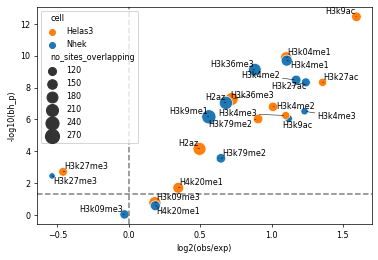

In [26]:
# plot seaborn scatterplot
plt.figure(figsize=(6,4))

sns.scatterplot(x='log2(obs/exp)', y='-log10(bh_p)', data=hist_df[~hist_df['hist'].str.contains('Ezh2|Ctcf|Pol2b')],\
            hue='cell', palette=['C1','C0'], size='no_sites_overlapping', sizes=(40,200))

plt.axhline(y=1.3010, ls='--', c='gray')
plt.axvline(x=0, ls='--', c='gray')


texts = []
for x, y, s in zip(hist_df[~hist_df['hist'].str.contains('Ezh2|Ctcf|Pol2b')]['log2(obs/exp)'], \
                   hist_df[~hist_df['hist'].str.contains('Ezh2|Ctcf|Pol2b')]['-log10(bh_p)'],   \
                   hist_df[~hist_df['hist'].str.contains('Ezh2|Ctcf|Pol2b')]['title']):
    texts.append(plt.text(x, y, s))



adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

#plt.show()
#plt.savefig('../figs/histone.svg')

In [27]:
####

In [28]:
#gw set of integrations
comb=pd.read_csv('../dataset/final_data/hpv_int/genome-wide_int.tsv', sep='\t')
comb

,chrom,start,end,sample,method,Author
0,chr2,195586244,195586544,TCGA-C5-A0TN,WGS,vifi
1,chr3,126848886,126849186,TCGA-C5-A0TN,WGS,vifi
2,chr4,29069328,29069628,TCGA-C5-A1BF,WGS,vifi
3,chr4,29071064,29071095,TCGA-C5-A1BF,WGS,vifi
4,chr4,74538776,74539076,TCGA-C5-A1BJ,WGS,vifi
5,chr4,74668359,74668659,TCGA-C5-A1BJ,WGS,vifi
6,chr18,61276726,61277026,TCGA-C5-A1BN,WGS,vifi
7,chr18,61373529,61373829,TCGA-C5-A1BN,WGS,vifi
8,chr10,97268882,97269182,TCGA-C5-A1M8,WGS,vifi
9,chr10,97518231,97518531,TCGA-C5-A1M8,WGS,vifi


In [29]:
# calculate center, then take 500 and 1 bp on each side
comb['c-500']=((comb['start']+comb['end'])/2).astype('int64')-500
comb['c+500']=((comb['start']+comb['end'])/2).astype('int64')+500
comb['c']    =((comb['start']+comb['end'])/2).astype('int64')
comb['c+1']  =comb['c']+1
comb

,chrom,start,end,sample,method,Author,c-500,c+500,c,c+1
0,chr2,195586244,195586544,TCGA-C5-A0TN,WGS,vifi,195585894,195586894,195586394,195586395
1,chr3,126848886,126849186,TCGA-C5-A0TN,WGS,vifi,126848536,126849536,126849036,126849037
2,chr4,29069328,29069628,TCGA-C5-A1BF,WGS,vifi,29068978,29069978,29069478,29069479
3,chr4,29071064,29071095,TCGA-C5-A1BF,WGS,vifi,29070579,29071579,29071079,29071080
4,chr4,74538776,74539076,TCGA-C5-A1BJ,WGS,vifi,74538426,74539426,74538926,74538927
5,chr4,74668359,74668659,TCGA-C5-A1BJ,WGS,vifi,74668009,74669009,74668509,74668510
6,chr18,61276726,61277026,TCGA-C5-A1BN,WGS,vifi,61276376,61277376,61276876,61276877
7,chr18,61373529,61373829,TCGA-C5-A1BN,WGS,vifi,61373179,61374179,61373679,61373680
8,chr10,97268882,97269182,TCGA-C5-A1M8,WGS,vifi,97268532,97269532,97269032,97269033
9,chr10,97518231,97518531,TCGA-C5-A1M8,WGS,vifi,97517881,97518881,97518381,97518382


In [30]:
print((comb['c+500']-comb['c-500']).value_counts())
print((comb['c+1']-comb['c']).value_counts())

1000    617
dtype: int64
1    617
dtype: int64


In [31]:
#check
print(comb['c-500'].equals(combined['1']))
print(comb['c+500'].equals(combined['2']))

True
True


In [32]:
# calculate center and 'c+1' in random gc corrected set of regions
ran_sites_gc['c']=((ran_sites_gc['start'].astype('int64')+ran_sites_gc['end'].astype('int64'))/2).astype('int64')
ran_sites_gc['c+1']=ran_sites_gc['c']+1
ran_sites_gc

,chr,start,end,c,c+1
0,chr6,98232979,98233979,98233479,98233480
1,chr10,28292609,28293609,28293109,28293110
2,chr1,198767263,198768263,198767763,198767764
3,chr15,97654854,97655854,97655354,97655355
4,chr2,235812936,235813936,235813436,235813437
5,chr12,51120001,51121001,51120501,51120502
6,chrX,40813161,40814161,40813661,40813662
7,chr12,47972758,47973758,47973258,47973259
8,chr7,105556655,105557655,105557155,105557156
9,chr9,100772751,100773751,100773251,100773252


In [33]:
(ran_sites_gc['c+1']-ran_sites_gc['c']).value_counts()

1    617
dtype: int64

# chromHMM, Roadmap

In [34]:
# hela s3, ROADMAP chromHMM, hg19
hela=pd.read_csv('../dataset/roadmap_chromHMM/E117_15_coreMarks_mnemonics.bed.gz', sep='\t', header=None)
hela

,0,1,2,3
0,chr10,0,119600,15_Quies
1,chr10,119600,120400,1_TssA
2,chr10,120400,122200,14_ReprPCWk
3,chr10,122200,122600,1_TssA
4,chr10,122600,159600,14_ReprPCWk
5,chr10,159600,178800,15_Quies
6,chr10,178800,180000,7_Enh
7,chr10,180000,180600,2_TssAFlnk
8,chr10,180600,182400,1_TssA
9,chr10,182400,183200,2_TssAFlnk


In [35]:
hela[3].value_counts()

7_Enh          84725
5_TxWk         66358
15_Quies       50243
2_TssAFlnk     41643
14_ReprPCWk    31463
4_Tx           26294
1_TssA         20519
13_ReprPC      18934
9_Het           9189
6_EnhG          7897
3_TxFlnk        3099
8_ZNF/Rpts      1834
12_EnhBiv        835
10_TssBiv        602
11_BivFlnk       406
Name: 3, dtype: int64

In [36]:
#remove numbers from the categories
hela[3]=hela[3].str.split('_', expand=True)[1]
print(hela[3].value_counts())
hela

Enh         84725
TxWk        66358
Quies       50243
TssAFlnk    41643
ReprPCWk    31463
Tx          26294
TssA        20519
ReprPC      18934
Het          9189
EnhG         7897
TxFlnk       3099
ZNF/Rpts     1834
EnhBiv        835
TssBiv        602
BivFlnk       406
Name: 3, dtype: int64


,0,1,2,3
0,chr10,0,119600,Quies
1,chr10,119600,120400,TssA
2,chr10,120400,122200,ReprPCWk
3,chr10,122200,122600,TssA
4,chr10,122600,159600,ReprPCWk
5,chr10,159600,178800,Quies
6,chr10,178800,180000,Enh
7,chr10,180000,180600,TssAFlnk
8,chr10,180600,182400,TssA
9,chr10,182400,183200,TssAFlnk


In [37]:
comb.head()

,chrom,start,end,sample,method,Author,c-500,c+500,c,c+1
0,chr2,195586244,195586544,TCGA-C5-A0TN,WGS,vifi,195585894,195586894,195586394,195586395
1,chr3,126848886,126849186,TCGA-C5-A0TN,WGS,vifi,126848536,126849536,126849036,126849037
2,chr4,29069328,29069628,TCGA-C5-A1BF,WGS,vifi,29068978,29069978,29069478,29069479
3,chr4,29071064,29071095,TCGA-C5-A1BF,WGS,vifi,29070579,29071579,29071079,29071080
4,chr4,74538776,74539076,TCGA-C5-A1BJ,WGS,vifi,74538426,74539426,74538926,74538927


In [38]:
# overlap comb int to chromHMM hela, only using the center pos
comb_hela=BedTool.from_dataframe(comb[['chrom', 'c', 'c+1', 'sample', 'method', 'Author']]).intersect(\
              BedTool.from_dataframe(hela), loj=True)
comb_hela=BedTool.to_dataframe(comb_hela)
comb_hela

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount
0,chr2,195586394,195586395,TCGA-C5-A0TN,WGS,vifi,chr2,195066400,195909000,Quies
1,chr3,126849036,126849037,TCGA-C5-A0TN,WGS,vifi,chr3,126846400,126851200,ReprPCWk
2,chr4,29069478,29069479,TCGA-C5-A1BF,WGS,vifi,chr4,28231200,29425600,Quies
3,chr4,29071079,29071080,TCGA-C5-A1BF,WGS,vifi,chr4,28231200,29425600,Quies
4,chr4,74538926,74538927,TCGA-C5-A1BJ,WGS,vifi,chr4,74486800,74541400,Quies
5,chr4,74668509,74668510,TCGA-C5-A1BJ,WGS,vifi,chr4,74642400,74698600,Quies
6,chr18,61276876,61276877,TCGA-C5-A1BN,WGS,vifi,chr18,61273000,61291600,Quies
7,chr18,61373679,61373680,TCGA-C5-A1BN,WGS,vifi,chr18,61352400,61382400,Quies
8,chr10,97269032,97269033,TCGA-C5-A1M8,WGS,vifi,chr10,97245800,97269200,Quies
9,chr10,97518381,97518382,TCGA-C5-A1M8,WGS,vifi,chr10,97517200,97542800,Quies


In [39]:
comb_hela[comb_hela['thickEnd']==-1]
# all overlap

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount


In [40]:
print(comb_hela['blockCount'].value_counts().sum())
comb_hela['blockCount'].value_counts()

617


Quies       364
TxWk         88
Enh          38
ReprPCWk     31
Tx           27
TssAFlnk     13
EnhG         11
ZNF/Rpts      9
Het           9
TxFlnk        8
TssA          8
ReprPC        8
BivFlnk       2
TssBiv        1
Name: blockCount, dtype: int64

In [41]:
# calculate percentage of overlap in each of the chromHMM categories
hela_df=comb_hela['blockCount'].value_counts().rename_axis('chromHMM').reset_index(name='observed_counts')
hela_df['percent']=(hela_df['observed_counts']/617)*100
hela_df                                

,chromHMM,observed_counts,percent
0,Quies,364,58.995138
1,TxWk,88,14.262561
2,Enh,38,6.158833
3,ReprPCWk,31,5.024311
4,Tx,27,4.376013
5,TssAFlnk,13,2.106969
6,EnhG,11,1.782820
7,ZNF/Rpts,9,1.458671
8,Het,9,1.458671
9,TxFlnk,8,1.296596


In [42]:
ran_sites_gc.head()

,chr,start,end,c,c+1
0,chr6,98232979,98233979,98233479,98233480
1,chr10,28292609,28293609,28293109,28293110
2,chr1,198767263,198768263,198767763,198767764
3,chr15,97654854,97655854,97655354,97655355
4,chr2,235812936,235813936,235813436,235813437


In [43]:
# overlap random sites to hela S3 chromHMM, only center pos
random_hela=BedTool.from_dataframe(ran_sites_gc[['chr', 'c', 'c+1']]).intersect(\
            BedTool.from_dataframe(hela), loj=True)
random_hela=BedTool.to_dataframe(random_hela)
random_hela

,chrom,start,end,name,score,strand,thickStart
0,chr6,98233479,98233480,chr6,98231200,98365600,Quies
1,chr10,28293109,28293110,chr10,28288200,28342400,Quies
2,chr1,198767763,198767764,chr1,198732600,198806400,Quies
3,chr15,97655354,97655355,chr15,97647400,97660800,Quies
4,chr2,235813436,235813437,chr2,235790800,235859600,Quies
5,chr12,51120501,51120502,chr12,51118200,51121000,TxWk
6,chrX,40813661,40813662,chrX,40813000,40823400,Quies
7,chr12,47973258,47973259,chr12,47938600,47997000,Quies
8,chr7,105557155,105557156,chr7,105519800,105607200,Quies
9,chr9,100773251,100773252,chr9,100763800,100781800,Tx


In [44]:
random_hela[random_hela['score']==-1]
#all overlap

,chrom,start,end,name,score,strand,thickStart


In [45]:
print(random_hela['thickStart'].value_counts().sum())
random_hela['thickStart'].value_counts()

617


Quies       400
ReprPCWk     82
TxWk         65
Enh          19
Tx           17
TssA         11
TssAFlnk      9
ReprPC        9
TxFlnk        2
ZNF/Rpts      1
EnhG          1
Het           1
Name: thickStart, dtype: int64

In [46]:
# merge random table with hela_df

a=random_hela['thickStart'].value_counts().rename_axis('chromHMM').reset_index(name='random_expected_counts')
print(a)
hela_df=hela_df.merge(a, on='chromHMM', how='left')
hela_df

    chromHMM  random_expected_counts
0      Quies                     400
1   ReprPCWk                      82
2       TxWk                      65
3        Enh                      19
4         Tx                      17
5       TssA                      11
6   TssAFlnk                       9
7     ReprPC                       9
8     TxFlnk                       2
9   ZNF/Rpts                       1
10      EnhG                       1
11       Het                       1


,chromHMM,observed_counts,percent,random_expected_counts
0,Quies,364,58.995138,400.0
1,TxWk,88,14.262561,65.0
2,Enh,38,6.158833,19.0
3,ReprPCWk,31,5.024311,82.0
4,Tx,27,4.376013,17.0
5,TssAFlnk,13,2.106969,9.0
6,EnhG,11,1.782820,1.0
7,ZNF/Rpts,9,1.458671,1.0
8,Het,9,1.458671,1.0
9,TxFlnk,8,1.296596,2.0


In [47]:
hela_df['random_expected_counts']=hela_df['random_expected_counts'].fillna(value=0)
hela_df['random_expected_counts']=hela_df['random_expected_counts'].astype('int64')
hela_df

,chromHMM,observed_counts,percent,random_expected_counts
0,Quies,364,58.995138,400
1,TxWk,88,14.262561,65
2,Enh,38,6.158833,19
3,ReprPCWk,31,5.024311,82
4,Tx,27,4.376013,17
5,TssAFlnk,13,2.106969,9
6,EnhG,11,1.782820,1
7,ZNF/Rpts,9,1.458671,1
8,Het,9,1.458671,1
9,TxFlnk,8,1.296596,2


In [48]:
hela[3].value_counts()

Enh         84725
TxWk        66358
Quies       50243
TssAFlnk    41643
ReprPCWk    31463
Tx          26294
TssA        20519
ReprPC      18934
Het          9189
EnhG         7897
TxFlnk       3099
ZNF/Rpts     1834
EnhBiv        835
TssBiv        602
BivFlnk       406
Name: 3, dtype: int64

In [49]:
# will follow this grouping order, 8 groups
hmm_list=[['TssA', 'TssAFlnk'], ['TxFlnk', 'Tx', 'TxWk'], ['EnhG', 'Enh'], ['ZNF/Rpts'], ['TssBiv', 'BivFlnk'],\
 ['EnhBiv'], ['ReprPC', 'ReprPCWk', 'Het'], ['Quies']]
hmm_list

[['TssA', 'TssAFlnk'],
 ['TxFlnk', 'Tx', 'TxWk'],
 ['EnhG', 'Enh'],
 ['ZNF/Rpts'],
 ['TssBiv', 'BivFlnk'],
 ['EnhBiv'],
 ['ReprPC', 'ReprPCWk', 'Het'],
 ['Quies']]

In [50]:
# active and inactive grouping
active_list={'active':['TssA', 'TssAFlnk', 'TxFlnk', 'Tx', 'TxWk', 'EnhG', 'Enh', 'ZNF/Rpts'],\
             'inactive':['Het', 'TssBiv', 'BivFlnk', 'EnhBiv', 'ReprPC', 'ReprPCWk', 'Quies']}
active_list

{'active': ['TssA',
  'TssAFlnk',
  'TxFlnk',
  'Tx',
  'TxWk',
  'EnhG',
  'Enh',
  'ZNF/Rpts'],
 'inactive': ['Het',
  'TssBiv',
  'BivFlnk',
  'EnhBiv',
  'ReprPC',
  'ReprPCWk',
  'Quies']}

In [51]:
# get observed and random counts for the chromHMM groups
frames=[]
for item in hmm_list:
    print(item)
    c=hela_df[hela_df['chromHMM'].isin(item)]
    frames.append([item, c['observed_counts'].sum(), c['random_expected_counts'].sum()])
    
#merge all together
hela_grp_df=pd.DataFrame(frames, columns=['chromHMM', 'observed_counts', 'random_expected_counts'])
hela_grp_df

['TssA', 'TssAFlnk']
['TxFlnk', 'Tx', 'TxWk']
['EnhG', 'Enh']
['ZNF/Rpts']
['TssBiv', 'BivFlnk']
['EnhBiv']
['ReprPC', 'ReprPCWk', 'Het']
['Quies']


,chromHMM,observed_counts,random_expected_counts
0,"[TssA, TssAFlnk]",21,20
1,"[TxFlnk, Tx, TxWk]",123,84
2,"[EnhG, Enh]",49,20
3,[ZNF/Rpts],9,1
4,"[TssBiv, BivFlnk]",3,0
5,[EnhBiv],0,0
6,"[ReprPC, ReprPCWk, Het]",48,92
7,[Quies],364,400


In [52]:
#check
print(hela_grp_df['random_expected_counts'].sum())
c

617


,chromHMM,observed_counts,percent,random_expected_counts
0,Quies,364,58.995138,400


In [53]:
#remove those with 0 observed counts and also join items in chromHMM types
hela_grp_df=hela_grp_df[hela_grp_df['observed_counts']!=0]
hela_grp_df['chromHMM']=hela_grp_df['chromHMM'].str.join(',')
hela_grp_df

/home/sabari/anuragks/miniconda3/envs/genomic_bl/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,chromHMM,observed_counts,random_expected_counts
0,"TssA,TssAFlnk",21,20
1,"TxFlnk,Tx,TxWk",123,84
2,"EnhG,Enh",49,20
3,ZNF/Rpts,9,1
4,"TssBiv,BivFlnk",3,0
6,"ReprPC,ReprPCWk,Het",48,92
7,Quies,364,400


In [54]:
# making 2x2 contingency table and doing chi square test for each chromHMM type groups
frames=[]
for index, row in hela_grp_df.iterrows():
    obs=np.array([[row['observed_counts'], 617-row['observed_counts']],\
                  [row['random_expected_counts'], 617-row['random_expected_counts']]])
    
    print(obs)
    chi2, p, dof, expected = chi2_contingency(obs)
    print(p)
    frames.append([row['chromHMM'], p])
    
#create df for chi square pvals
hela_grp_pval=pd.DataFrame(frames, columns=['chromHMM', 'chi-pval'])
print(len(hela_grp_pval))

# merge with original df
hela_grp_df=hela_grp_df.merge(hela_grp_pval, on='chromHMM', how='left')
hela_grp_df

[[ 21 596]
 [ 20 597]]
1.0
[[123 494]
 [ 84 533]]
0.0037897970681726643
[[ 49 568]
 [ 20 597]]
0.0005220298604492387
[[  9 608]
 [  1 616]]
0.02624154048021531
[[  3 614]
 [  0 617]]
0.2476375119109115
[[ 48 569]
 [ 92 525]]
0.00011352710863774787
[[364 253]
 [400 217]]
0.040191404398179614
7


,chromHMM,observed_counts,random_expected_counts,chi-pval
0,"TssA,TssAFlnk",21,20,1.000000
1,"TxFlnk,Tx,TxWk",123,84,0.003790
2,"EnhG,Enh",49,20,0.000522
3,ZNF/Rpts,9,1,0.026242
4,"TssBiv,BivFlnk",3,0,0.247638
5,"ReprPC,ReprPCWk,Het",48,92,0.000114
6,Quies,364,400,0.040191


In [55]:
# multiple test correction 
hela_grp_df['bh_p']=mlpt(hela_grp_df['chi-pval'], method='fdr_bh')[1]
hela_grp_df

,chromHMM,observed_counts,random_expected_counts,chi-pval,bh_p
0,"TssA,TssAFlnk",21,20,1.000000,1.000000
1,"TxFlnk,Tx,TxWk",123,84,0.003790,0.008843
2,"EnhG,Enh",49,20,0.000522,0.001827
3,ZNF/Rpts,9,1,0.026242,0.045923
4,"TssBiv,BivFlnk",3,0,0.247638,0.288910
5,"ReprPC,ReprPCWk,Het",48,92,0.000114,0.000795
6,Quies,364,400,0.040191,0.056268


In [56]:
#calculate log2(obs/exp) and negative log10(bh_p)
hela_grp_df['log2(obs/exp)']=np.log2((hela_grp_df['observed_counts']/hela_grp_df['random_expected_counts']))
hela_grp_df['-log10(bh_p)']=np.log10(hela_grp_df['bh_p'])*-1
hela_grp_df

,chromHMM,observed_counts,random_expected_counts,chi-pval,bh_p,log2(obs/exp),-log10(bh_p)
0,"TssA,TssAFlnk",21,20,1.000000,1.000000,0.070389,-0.000000
1,"TxFlnk,Tx,TxWk",123,84,0.003790,0.008843,0.550197,2.053407
2,"EnhG,Enh",49,20,0.000522,0.001827,1.292782,2.738237
3,ZNF/Rpts,9,1,0.026242,0.045923,3.169925,1.337973
4,"TssBiv,BivFlnk",3,0,0.247638,0.288910,inf,0.539237
5,"ReprPC,ReprPCWk,Het",48,92,0.000114,0.000795,-0.938599,3.099802
6,Quies,364,400,0.040191,0.056268,-0.136062,1.249739


In [57]:
# remove TssBiv,BivFlnk
hela_grp_df=hela_grp_df[hela_grp_df['chromHMM']!='TssBiv,BivFlnk']
hela_grp_df

,chromHMM,observed_counts,random_expected_counts,chi-pval,bh_p,log2(obs/exp),-log10(bh_p)
0,"TssA,TssAFlnk",21,20,1.000000,1.000000,0.070389,-0.000000
1,"TxFlnk,Tx,TxWk",123,84,0.003790,0.008843,0.550197,2.053407
2,"EnhG,Enh",49,20,0.000522,0.001827,1.292782,2.738237
3,ZNF/Rpts,9,1,0.026242,0.045923,3.169925,1.337973
5,"ReprPC,ReprPCWk,Het",48,92,0.000114,0.000795,-0.938599,3.099802
6,Quies,364,400,0.040191,0.056268,-0.136062,1.249739


In [58]:
#title 
hela_grp_df['title']=hela_grp_df['chromHMM'] + ' (' + hela_grp_df['observed_counts'].astype('str') + ')'
hela_grp_df

/home/sabari/anuragks/miniconda3/envs/genomic_bl/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,chromHMM,observed_counts,random_expected_counts,chi-pval,bh_p,log2(obs/exp),-log10(bh_p),title
0,"TssA,TssAFlnk",21,20,1.000000,1.000000,0.070389,-0.000000,"TssA,TssAFlnk (21)"
1,"TxFlnk,Tx,TxWk",123,84,0.003790,0.008843,0.550197,2.053407,"TxFlnk,Tx,TxWk (123)"
2,"EnhG,Enh",49,20,0.000522,0.001827,1.292782,2.738237,"EnhG,Enh (49)"
3,ZNF/Rpts,9,1,0.026242,0.045923,3.169925,1.337973,ZNF/Rpts (9)
5,"ReprPC,ReprPCWk,Het",48,92,0.000114,0.000795,-0.938599,3.099802,"ReprPC,ReprPCWk,Het (48)"
6,Quies,364,400,0.040191,0.056268,-0.136062,1.249739,Quies (364)


In [59]:
hela_grp_df['sig'] = hela_grp_df.apply(lambda x: 'yes' if x['bh_p']<0.05 else 'no', axis=1)
hela_grp_df

/home/sabari/anuragks/miniconda3/envs/genomic_bl/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,chromHMM,observed_counts,random_expected_counts,chi-pval,bh_p,log2(obs/exp),-log10(bh_p),title,sig
0,"TssA,TssAFlnk",21,20,1.000000,1.000000,0.070389,-0.000000,"TssA,TssAFlnk (21)",no
1,"TxFlnk,Tx,TxWk",123,84,0.003790,0.008843,0.550197,2.053407,"TxFlnk,Tx,TxWk (123)",yes
2,"EnhG,Enh",49,20,0.000522,0.001827,1.292782,2.738237,"EnhG,Enh (49)",yes
3,ZNF/Rpts,9,1,0.026242,0.045923,3.169925,1.337973,ZNF/Rpts (9),yes
5,"ReprPC,ReprPCWk,Het",48,92,0.000114,0.000795,-0.938599,3.099802,"ReprPC,ReprPCWk,Het (48)",yes
6,Quies,364,400,0.040191,0.056268,-0.136062,1.249739,Quies (364),no


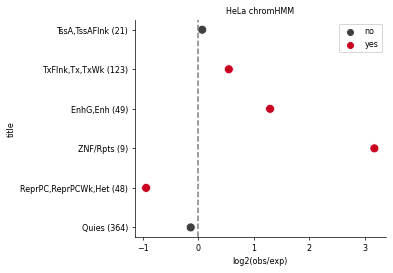

In [60]:
# plot scatter plot 
fig, ax = plt.subplots()
fig.set_size_inches(4.5,4)

sns.scatterplot(x='log2(obs/exp)', y='title', hue='sig', data=hela_grp_df, s=80, ax=ax, \
                palette=['#404040', '#ca0020'])
sns.despine()

plt.axvline(0, linestyle="--", color="gray")
plt.title('HeLa chromHMM')
plt.legend(loc=1)
#plt.savefig('../figs/hela_chrom.svg')

In [61]:
###

In [62]:
# get obs and exp in active and inactive regions
frames=[]
for key, value in active_list.items():
    print(key, value)
    c=hela_df[hela_df['chromHMM'].isin(value)]
    frames.append([key, c['observed_counts'].sum(), c['random_expected_counts'].sum()])
    
#merge all
hela_ac_df=pd.DataFrame(frames, columns=['chromHMM', 'observed_counts', 'random_expected_counts'])
hela_ac_df

active ['TssA', 'TssAFlnk', 'TxFlnk', 'Tx', 'TxWk', 'EnhG', 'Enh', 'ZNF/Rpts']
inactive ['Het', 'TssBiv', 'BivFlnk', 'EnhBiv', 'ReprPC', 'ReprPCWk', 'Quies']


,chromHMM,observed_counts,random_expected_counts
0,active,202,125
1,inactive,415,492


In [63]:
#check
print(hela_ac_df['random_expected_counts'].sum())
c

617


,chromHMM,observed_counts,percent,random_expected_counts
0,Quies,364,58.995138,400
3,ReprPCWk,31,5.024311,82
8,Het,9,1.458671,1
11,ReprPC,8,1.296596,9
12,BivFlnk,2,0.324149,0
13,TssBiv,1,0.162075,0


In [64]:
hela_ac_df.melt(id_vars=['chromHMM'], value_vars=['observed_counts', 'random_expected_counts'])

,chromHMM,variable,value
0,active,observed_counts,202
1,inactive,observed_counts,415
2,active,random_expected_counts,125
3,inactive,random_expected_counts,492


In [65]:
#p values from one sample chi-square test in R

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

active_observed_counts vs. active_random_expected_counts: P=2.06e-05
inactive_observed_counts vs. inactive_random_expected_counts: P=0.01


/home/sabari/anuragks/miniconda3/envs/genomic_bl/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/home/sabari/anuragks/miniconda3/envs/genomic_bl/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


Text(10.375, 0.5, 'No of HPV integrations')

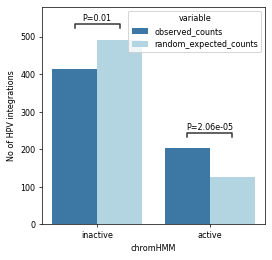

In [66]:
#https://github.com/trevismd/statannotations-tutorials/blob/main/Tutorial_1/Statannotations-Tutorial-1.ipynb

# plt obs and exp in active and inactive
plt.figure(figsize=(4,4))

pairs=[[('active', 'observed_counts'), ('active', 'random_expected_counts')],\
       [('inactive', 'observed_counts'), ('inactive', 'random_expected_counts')]]

pvalues=['P=2.06e-05', 'P=0.01']

ax=sns.barplot(x='chromHMM', y='value', hue='variable', \
        data=hela_ac_df.melt(id_vars=['chromHMM'], value_vars=['observed_counts', 'random_expected_counts']),\
        order=['inactive', 'active'], palette=['#2c7bb6', '#abd9e9'])

# Add annotations
annotator = Annotator(ax, pairs, plot='barplot', x='chromHMM', y='value', hue='variable', \
        data=hela_ac_df.melt(id_vars=['chromHMM'], value_vars=['observed_counts', 'random_expected_counts']), \
        order=['inactive', 'active'], palette=['#2c7bb6', '#abd9e9'])
annotator.set_custom_annotations(pvalues)
annotator.annotate()

plt.ylabel('No of HPV integrations')
#plt.savefig('../figs/fig1/hela_chrom_ac.svg')


In [67]:
##

# NHEK chromHMM

In [68]:
# NHEK chromHMM,ROADMAP,  hg19
nhek=pd.read_csv('../dataset/roadmap_chromHMM/E127_15_coreMarks_mnemonics.bed.gz', sep='\t', header=None)
nhek

,0,1,2,3
0,chr10,0,109600,15_Quies
1,chr10,109600,119600,14_ReprPCWk
2,chr10,119600,120000,10_TssBiv
3,chr10,120000,120200,1_TssA
4,chr10,120200,122000,14_ReprPCWk
5,chr10,122000,122200,11_BivFlnk
6,chr10,122200,122600,1_TssA
7,chr10,122600,125400,14_ReprPCWk
8,chr10,125400,126800,13_ReprPC
9,chr10,126800,133400,14_ReprPCWk


In [69]:
print(len(nhek[3].value_counts()))
nhek[3].value_counts()

15


7_Enh          109762
15_Quies        87169
5_TxWk          83558
9_Het           43671
2_TssAFlnk      43012
14_ReprPCWk     39240
4_Tx            33575
13_ReprPC       23429
1_TssA          17854
6_EnhG          14689
12_EnhBiv        6038
11_BivFlnk       5068
10_TssBiv        4593
3_TxFlnk         4381
8_ZNF/Rpts       3598
Name: 3, dtype: int64

In [70]:
# remove numbers from chromHMM types
nhek[3]=nhek[3].str.split('_', expand=True)[1]
print(nhek[3].value_counts())
nhek

Enh         109762
Quies        87169
TxWk         83558
Het          43671
TssAFlnk     43012
ReprPCWk     39240
Tx           33575
ReprPC       23429
TssA         17854
EnhG         14689
EnhBiv        6038
BivFlnk       5068
TssBiv        4593
TxFlnk        4381
ZNF/Rpts      3598
Name: 3, dtype: int64


,0,1,2,3
0,chr10,0,109600,Quies
1,chr10,109600,119600,ReprPCWk
2,chr10,119600,120000,TssBiv
3,chr10,120000,120200,TssA
4,chr10,120200,122000,ReprPCWk
5,chr10,122000,122200,BivFlnk
6,chr10,122200,122600,TssA
7,chr10,122600,125400,ReprPCWk
8,chr10,125400,126800,ReprPC
9,chr10,126800,133400,ReprPCWk


In [71]:
comb.head()

,chrom,start,end,sample,method,Author,c-500,c+500,c,c+1
0,chr2,195586244,195586544,TCGA-C5-A0TN,WGS,vifi,195585894,195586894,195586394,195586395
1,chr3,126848886,126849186,TCGA-C5-A0TN,WGS,vifi,126848536,126849536,126849036,126849037
2,chr4,29069328,29069628,TCGA-C5-A1BF,WGS,vifi,29068978,29069978,29069478,29069479
3,chr4,29071064,29071095,TCGA-C5-A1BF,WGS,vifi,29070579,29071579,29071079,29071080
4,chr4,74538776,74539076,TCGA-C5-A1BJ,WGS,vifi,74538426,74539426,74538926,74538927


In [72]:
# overlap comb int to  nhek chromHMM, only center pos
comb_nhek=BedTool.from_dataframe(comb[['chrom', 'c', 'c+1', 'sample', 'method', 'Author']]).intersect(\
              BedTool.from_dataframe(nhek), loj=True)
comb_nhek=BedTool.to_dataframe(comb_nhek)
comb_nhek

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount
0,chr2,195586394,195586395,TCGA-C5-A0TN,WGS,vifi,chr2,195309600,195589400,Quies
1,chr3,126849036,126849037,TCGA-C5-A0TN,WGS,vifi,chr3,126832200,126852400,ReprPCWk
2,chr4,29069478,29069479,TCGA-C5-A1BF,WGS,vifi,chr4,28975400,29174600,Quies
3,chr4,29071079,29071080,TCGA-C5-A1BF,WGS,vifi,chr4,28975400,29174600,Quies
4,chr4,74538926,74538927,TCGA-C5-A1BJ,WGS,vifi,chr4,74536000,74540000,TxWk
5,chr4,74668509,74668510,TCGA-C5-A1BJ,WGS,vifi,chr4,74642400,74679800,Quies
6,chr18,61276876,61276877,TCGA-C5-A1BN,WGS,vifi,chr18,61273400,61291800,Quies
7,chr18,61373679,61373680,TCGA-C5-A1BN,WGS,vifi,chr18,61352400,61375800,Quies
8,chr10,97269032,97269033,TCGA-C5-A1M8,WGS,vifi,chr10,97216800,97272600,Quies
9,chr10,97518381,97518382,TCGA-C5-A1M8,WGS,vifi,chr10,97453800,97573800,Quies


In [73]:
comb_nhek[comb_nhek['thickEnd']==-1]
# All overlapping

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount


In [74]:
print(comb_nhek['blockCount'].value_counts().sum())
comb_nhek['blockCount'].value_counts()

617


Quies       301
TxWk        108
Enh          68
ReprPCWk     32
Tx           29
Het          24
ZNF/Rpts     14
TssAFlnk     13
EnhG          9
TssA          8
TxFlnk        5
BivFlnk       3
TssBiv        2
ReprPC        1
Name: blockCount, dtype: int64

In [75]:
# calculate percentage of overlap in each of the chromHMM categories
nhek_df=comb_nhek['blockCount'].value_counts().rename_axis('chromHMM').reset_index(name='observed_counts')
nhek_df['percent']=(nhek_df['observed_counts']/617)*100
nhek_df


,chromHMM,observed_counts,percent
0,Quies,301,48.784441
1,TxWk,108,17.504052
2,Enh,68,11.021070
3,ReprPCWk,32,5.186386
4,Tx,29,4.700162
5,Het,24,3.889789
6,ZNF/Rpts,14,2.269044
7,TssAFlnk,13,2.106969
8,EnhG,9,1.458671
9,TssA,8,1.296596


In [76]:
ran_sites_gc.head()

,chr,start,end,c,c+1
0,chr6,98232979,98233979,98233479,98233480
1,chr10,28292609,28293609,28293109,28293110
2,chr1,198767263,198768263,198767763,198767764
3,chr15,97654854,97655854,97655354,97655355
4,chr2,235812936,235813936,235813436,235813437


In [77]:
# overlap random gc corrected regions to nhek chromHMM, only center pos
random_nhek=BedTool.from_dataframe(ran_sites_gc[['chr', 'c', 'c+1']]).intersect(\
            BedTool.from_dataframe(nhek), loj=True)
random_nhek=BedTool.to_dataframe(random_nhek)
random_nhek

,chrom,start,end,name,score,strand,thickStart
0,chr6,98233479,98233480,chr6,98213600,98238600,Quies
1,chr10,28293109,28293110,chr10,28290600,28342800,Quies
2,chr1,198767763,198767764,chr1,198767400,198798800,Quies
3,chr15,97655354,97655355,chr15,97647400,97677600,Quies
4,chr2,235813436,235813437,chr2,235797000,235833600,Quies
5,chr12,51120501,51120502,chr12,51120200,51121200,TxWk
6,chrX,40813661,40813662,chrX,40805000,40815600,Quies
7,chr12,47973258,47973259,chr12,47950800,47997000,Quies
8,chr7,105557155,105557156,chr7,105551800,105592000,Quies
9,chr9,100773251,100773252,chr9,100755200,100783800,Tx


In [78]:
print(random_nhek['thickStart'].value_counts().sum())
random_nhek['thickStart'].value_counts()

617


Quies       360
TxWk         78
ReprPCWk     75
Tx           25
Het          23
Enh          20
ReprPC       13
TssAFlnk      8
TssA          7
TxFlnk        3
EnhG          2
BivFlnk       1
ZNF/Rpts      1
TssBiv        1
Name: thickStart, dtype: int64

In [79]:
# merge random table with comb table

a=random_nhek['thickStart'].value_counts().rename_axis('chromHMM').reset_index(name='random_expected_counts')
print(a)
nhek_df=nhek_df.merge(a, on='chromHMM', how='left')
nhek_df

    chromHMM  random_expected_counts
0      Quies                     360
1       TxWk                      78
2   ReprPCWk                      75
3         Tx                      25
4        Het                      23
5        Enh                      20
6     ReprPC                      13
7   TssAFlnk                       8
8       TssA                       7
9     TxFlnk                       3
10      EnhG                       2
11   BivFlnk                       1
12  ZNF/Rpts                       1
13    TssBiv                       1


,chromHMM,observed_counts,percent,random_expected_counts
0,Quies,301,48.784441,360
1,TxWk,108,17.504052,78
2,Enh,68,11.021070,20
3,ReprPCWk,32,5.186386,75
4,Tx,29,4.700162,25
5,Het,24,3.889789,23
6,ZNF/Rpts,14,2.269044,1
7,TssAFlnk,13,2.106969,8
8,EnhG,9,1.458671,2
9,TssA,8,1.296596,7


In [80]:
hmm_list

[['TssA', 'TssAFlnk'],
 ['TxFlnk', 'Tx', 'TxWk'],
 ['EnhG', 'Enh'],
 ['ZNF/Rpts'],
 ['TssBiv', 'BivFlnk'],
 ['EnhBiv'],
 ['ReprPC', 'ReprPCWk', 'Het'],
 ['Quies']]

In [81]:
nhek[3].value_counts()

Enh         109762
Quies        87169
TxWk         83558
Het          43671
TssAFlnk     43012
ReprPCWk     39240
Tx           33575
ReprPC       23429
TssA         17854
EnhG         14689
EnhBiv        6038
BivFlnk       5068
TssBiv        4593
TxFlnk        4381
ZNF/Rpts      3598
Name: 3, dtype: int64

In [82]:
# get observed and random counts for the chromHMM groups
frames=[]
for item in hmm_list:
    print(item)
    c=nhek_df[nhek_df['chromHMM'].isin(item)]
    frames.append([item, c['observed_counts'].sum(), c['random_expected_counts'].sum()])
    
#merge all together
nhek_grp_df=pd.DataFrame(frames, columns=['chromHMM', 'observed_counts', 'random_expected_counts'])
nhek_grp_df

['TssA', 'TssAFlnk']
['TxFlnk', 'Tx', 'TxWk']
['EnhG', 'Enh']
['ZNF/Rpts']
['TssBiv', 'BivFlnk']
['EnhBiv']
['ReprPC', 'ReprPCWk', 'Het']
['Quies']


,chromHMM,observed_counts,random_expected_counts
0,"[TssA, TssAFlnk]",21,15
1,"[TxFlnk, Tx, TxWk]",142,106
2,"[EnhG, Enh]",77,22
3,[ZNF/Rpts],14,1
4,"[TssBiv, BivFlnk]",5,2
5,[EnhBiv],0,0
6,"[ReprPC, ReprPCWk, Het]",57,111
7,[Quies],301,360


In [83]:
print(nhek_grp_df['random_expected_counts'].sum())
c

617


,chromHMM,observed_counts,percent,random_expected_counts
0,Quies,301,48.784441,360


In [84]:
#remove those with 0 observed counts and also join items in chromHMM types
nhek_grp_df=nhek_grp_df[nhek_grp_df['observed_counts']!=0]
nhek_grp_df['chromHMM']=nhek_grp_df['chromHMM'].str.join(',')
nhek_grp_df

/home/sabari/anuragks/miniconda3/envs/genomic_bl/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,chromHMM,observed_counts,random_expected_counts
0,"TssA,TssAFlnk",21,15
1,"TxFlnk,Tx,TxWk",142,106
2,"EnhG,Enh",77,22
3,ZNF/Rpts,14,1
4,"TssBiv,BivFlnk",5,2
6,"ReprPC,ReprPCWk,Het",57,111
7,Quies,301,360


In [85]:
# making 2x2 contingency table and doing chi square test for each chromHMM type groups
frames=[]
for index, row in nhek_grp_df.iterrows():
    obs=np.array([[row['observed_counts'], 617-row['observed_counts']],\
                  [row['random_expected_counts'], 617-row['random_expected_counts']]])
    
    print(obs)
    chi2, p, dof, expected = chi2_contingency(obs)
    print(p)
    frames.append([row['chromHMM'], p])
    
#create df for chi square pvals
nhek_grp_pval=pd.DataFrame(frames, columns=['chromHMM', 'chi-pval'])
print(len(nhek_grp_pval))

# merge with original df
nhek_grp_df=nhek_grp_df.merge(nhek_grp_pval, on='chromHMM', how='left')
nhek_grp_df

[[ 21 596]
 [ 15 602]]
0.3976857928115112
[[142 475]
 [106 511]]
0.012906291107506372
[[ 77 540]
 [ 22 595]]
1.5230243649658335e-08
[[ 14 603]
 [  1 616]]
0.0018245910933500894
[[  5 612]
 [  2 615]]
0.4484018013848664
[[ 57 560]
 [111 506]]
1.0851635867358515e-05
[[301 316]
 [360 257]]
0.0009309409714773836
7


,chromHMM,observed_counts,random_expected_counts,chi-pval
0,"TssA,TssAFlnk",21,15,3.976858e-01
1,"TxFlnk,Tx,TxWk",142,106,1.290629e-02
2,"EnhG,Enh",77,22,1.523024e-08
3,ZNF/Rpts,14,1,1.824591e-03
4,"TssBiv,BivFlnk",5,2,4.484018e-01
5,"ReprPC,ReprPCWk,Het",57,111,1.085164e-05
6,Quies,301,360,9.309410e-04


In [86]:
# multiple test correction 
nhek_grp_df['bh_p']=mlpt(nhek_grp_df['chi-pval'], method='fdr_bh')[1]
nhek_grp_df

,chromHMM,observed_counts,random_expected_counts,chi-pval,bh_p
0,"TssA,TssAFlnk",21,15,3.976858e-01,4.484018e-01
1,"TxFlnk,Tx,TxWk",142,106,1.290629e-02,1.806881e-02
2,"EnhG,Enh",77,22,1.523024e-08,1.066117e-07
3,ZNF/Rpts,14,1,1.824591e-03,3.193034e-03
4,"TssBiv,BivFlnk",5,2,4.484018e-01,4.484018e-01
5,"ReprPC,ReprPCWk,Het",57,111,1.085164e-05,3.798073e-05
6,Quies,301,360,9.309410e-04,2.172196e-03


In [87]:
#calculate log2(obs/exp) and negative log10(bh_p)
nhek_grp_df['log2(obs/exp)']=np.log2((nhek_grp_df['observed_counts']/nhek_grp_df['random_expected_counts']))
nhek_grp_df['-log10(bh_p)']=np.log10(nhek_grp_df['bh_p'])*-1
nhek_grp_df

,chromHMM,observed_counts,random_expected_counts,chi-pval,bh_p,log2(obs/exp),-log10(bh_p)
0,"TssA,TssAFlnk",21,15,3.976858e-01,4.484018e-01,0.485427,0.348333
1,"TxFlnk,Tx,TxWk",142,106,1.290629e-02,1.806881e-02,0.421827,1.743071
2,"EnhG,Enh",77,22,1.523024e-08,1.066117e-07,1.807355,6.972195
3,ZNF/Rpts,14,1,1.824591e-03,3.193034e-03,3.807355,2.495796
4,"TssBiv,BivFlnk",5,2,4.484018e-01,4.484018e-01,1.321928,0.348333
5,"ReprPC,ReprPCWk,Het",57,111,1.085164e-05,3.798073e-05,-0.961526,4.420437
6,Quies,301,360,9.309410e-04,2.172196e-03,-0.258233,2.663101


In [88]:
#title 
nhek_grp_df['title']=nhek_grp_df['chromHMM'] + ' (' + nhek_grp_df['observed_counts'].astype('str') + ')'
nhek_grp_df

,chromHMM,observed_counts,random_expected_counts,chi-pval,bh_p,log2(obs/exp),-log10(bh_p),title
0,"TssA,TssAFlnk",21,15,3.976858e-01,4.484018e-01,0.485427,0.348333,"TssA,TssAFlnk (21)"
1,"TxFlnk,Tx,TxWk",142,106,1.290629e-02,1.806881e-02,0.421827,1.743071,"TxFlnk,Tx,TxWk (142)"
2,"EnhG,Enh",77,22,1.523024e-08,1.066117e-07,1.807355,6.972195,"EnhG,Enh (77)"
3,ZNF/Rpts,14,1,1.824591e-03,3.193034e-03,3.807355,2.495796,ZNF/Rpts (14)
4,"TssBiv,BivFlnk",5,2,4.484018e-01,4.484018e-01,1.321928,0.348333,"TssBiv,BivFlnk (5)"
5,"ReprPC,ReprPCWk,Het",57,111,1.085164e-05,3.798073e-05,-0.961526,4.420437,"ReprPC,ReprPCWk,Het (57)"
6,Quies,301,360,9.309410e-04,2.172196e-03,-0.258233,2.663101,Quies (301)


In [89]:
nhek_grp_df['sig'] = nhek_grp_df.apply(lambda x: 'yes' if x['bh_p']<0.05 else 'no', axis=1)
nhek_grp_df

,chromHMM,observed_counts,random_expected_counts,chi-pval,bh_p,log2(obs/exp),-log10(bh_p),title,sig
0,"TssA,TssAFlnk",21,15,3.976858e-01,4.484018e-01,0.485427,0.348333,"TssA,TssAFlnk (21)",no
1,"TxFlnk,Tx,TxWk",142,106,1.290629e-02,1.806881e-02,0.421827,1.743071,"TxFlnk,Tx,TxWk (142)",yes
2,"EnhG,Enh",77,22,1.523024e-08,1.066117e-07,1.807355,6.972195,"EnhG,Enh (77)",yes
3,ZNF/Rpts,14,1,1.824591e-03,3.193034e-03,3.807355,2.495796,ZNF/Rpts (14),yes
4,"TssBiv,BivFlnk",5,2,4.484018e-01,4.484018e-01,1.321928,0.348333,"TssBiv,BivFlnk (5)",no
5,"ReprPC,ReprPCWk,Het",57,111,1.085164e-05,3.798073e-05,-0.961526,4.420437,"ReprPC,ReprPCWk,Het (57)",yes
6,Quies,301,360,9.309410e-04,2.172196e-03,-0.258233,2.663101,Quies (301),yes


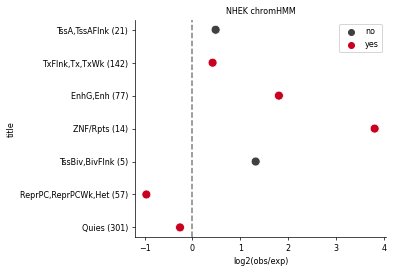

In [90]:
# plot scatter plot 
fig, ax = plt.subplots()
fig.set_size_inches(4.5, 4)

sns.scatterplot(x='log2(obs/exp)', y='title', hue='sig', data=nhek_grp_df, s=80, ax=ax, \
                palette=['#404040', '#ca0020'])
sns.despine()

plt.axvline(0, linestyle="--", color="gray")
plt.title('NHEK chromHMM')
plt.legend(loc=1)
#plt.savefig('../figs/nhek_chrom.svg')

In [91]:
# get obs and exp in active and inactive regions
frames=[]
for key, value in active_list.items():
    print(key, value)
    c=nhek_df[nhek_df['chromHMM'].isin(value)]
    frames.append([key, c['observed_counts'].sum(), c['random_expected_counts'].sum()])
    
#merge all
nhek_ac_df=pd.DataFrame(frames, columns=['chromHMM', 'observed_counts', 'random_expected_counts'])
nhek_ac_df

active ['TssA', 'TssAFlnk', 'TxFlnk', 'Tx', 'TxWk', 'EnhG', 'Enh', 'ZNF/Rpts']
inactive ['Het', 'TssBiv', 'BivFlnk', 'EnhBiv', 'ReprPC', 'ReprPCWk', 'Quies']


,chromHMM,observed_counts,random_expected_counts
0,active,254,144
1,inactive,363,473


In [92]:
print(nhek_ac_df['random_expected_counts'].sum())
c

617


,chromHMM,observed_counts,percent,random_expected_counts
0,Quies,301,48.784441,360
3,ReprPCWk,32,5.186386,75
5,Het,24,3.889789,23
11,BivFlnk,3,0.486224,1
12,TssBiv,2,0.324149,1
13,ReprPC,1,0.162075,13


In [93]:
c['random_expected_counts'].sum()

473

In [94]:
# p values calculated using one sample chi-squared test in R

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

active_observed_counts vs. active_random_expected_counts: P=3.51e-08
inactive_observed_counts vs. inactive_random_expected_counts: P=0.00014


/home/sabari/anuragks/miniconda3/envs/genomic_bl/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/home/sabari/anuragks/miniconda3/envs/genomic_bl/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


Text(10.375, 0.5, 'No of HPV integrations')

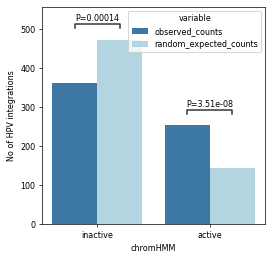

In [95]:
#https://github.com/trevismd/statannotations-tutorials/blob/main/Tutorial_1/Statannotations-Tutorial-1.ipynb

# plt obs and exp in active and inactive, for nhek chromHMM
plt.figure(figsize=(4,4))

pairs=[[('active', 'observed_counts'), ('active', 'random_expected_counts')],\
       [('inactive', 'observed_counts'), ('inactive', 'random_expected_counts')]]

pvalues=['P=3.51e-08', 'P=0.00014']

ax=sns.barplot(x='chromHMM', y='value', hue='variable', \
        data=nhek_ac_df.melt(id_vars=['chromHMM'], value_vars=['observed_counts', 'random_expected_counts']),\
        order=['inactive', 'active'], palette=['#2c7bb6', '#abd9e9'])

# Add annotations
annotator = Annotator(ax, pairs, plot='barplot', x='chromHMM', y='value', hue='variable', \
        data=nhek_ac_df.melt(id_vars=['chromHMM'], value_vars=['observed_counts', 'random_expected_counts']),\
        order=['inactive', 'active'], palette=['#2c7bb6', '#abd9e9'])
annotator.set_custom_annotations(pvalues)
annotator.annotate()

plt.ylabel('No of HPV integrations')
#plt.savefig('../figs/fig1/nhek_chrom_ac.svg')


In [96]:
############